### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np

In [2]:
ns = pd.read_csv("C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\m5_ns.csv",dtype={"sales": "float32"})

In [3]:
ns

,series_id
0,CA_2_FOODS_3_294
1,CA_2_HOUSEHOLD_1_079
2,CA_3_HOUSEHOLD_1_277
3,WI_1_FOODS_3_006
4,TX_1_HOUSEHOLD_1_043
...,...
495,CA_1_FOODS_3_135
496,CA_2_HOUSEHOLD_1_032
497,CA_3_FOODS_2_147
498,CA_1_FOODS_1_042


In [4]:
import pandas as pd

In [6]:
sales_wide  = pd.read_csv("C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\raw_data\\sales_train_validation.csv")
calendar    = pd.read_csv("C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\raw_data\\calendar.csv", parse_dates=["date"])
prices      = pd.read_csv("C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\raw_data\\sell_prices.csv")
ns_ids      = pd.read_csv("C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\m5_ns.csv", dtype=str)

In [7]:
# Constructing a series_id and id_base column for merging purposes
sales_wide["series_id"] = sales_wide["store_id"].astype(str) + "_" + sales_wide["item_id"].astype(str)
sales_wide["id_base"]   = sales_wide["id"].str.replace(r"_(validation|evaluation)$", "", regex=True)

In [8]:
# normalizing ns_ids to series_id column
if "series_id" in ns_ids.columns:
    ns_series = ns_ids["series_id"].dropna().unique()
elif "id" in ns_ids.columns:
    # Some M5 ids end with _validation or _evaluation. Removing these endings to get the base id
    tmp = ns_ids["id"].str.replace(r"_(validation|evaluation)$", "", regex=True).rename("id_base")
    ns_series = (
        sales_wide[["id_base","series_id"]].drop_duplicates()
        .merge(tmp.to_frame().drop_duplicates(), on="id_base", how="inner")["series_id"]
        .unique()
    )
else:
    raise KeyError("m5_ns.csv must contain either 'series_id' or 'id'")

In [9]:
# filtering rows to the non-stationary set
sel = sales_wide[sales_wide["series_id"].isin(ns_series)].copy()
print(f"Matched {len(sel)} SKUs of {len(sales_wide)} total")

# melting only the selected rows
id_vars    = ["id","item_id","dept_id","cat_id","store_id","state_id","series_id","id_base"]
value_vars = [c for c in sales_wide.columns if c.startswith("d_")]
sales = (
    sel.melt(id_vars=id_vars, value_vars=value_vars,
             var_name="d", value_name="sales")
      .astype({"sales": "float32"})
)

# calendar merge 
cal_sel = calendar[[
    "d","date","wm_yr_wk","weekday","wday","month","year",
    "event_name_1","event_type_1","event_name_2","event_type_2",
    "snap_CA","snap_TX","snap_WI"
]]
sales = sales.merge(cal_sel, on="d", how="left")

# prices merge
sales = sales.merge(
    prices[["store_id","item_id","wm_yr_wk","sell_price"]],
    on=["store_id","item_id","wm_yr_wk"], how="left"
)

Matched 500 SKUs of 30490 total


In [10]:
# Filling the missing sell_price values within each (store_id, item_id) group by carrying
# the last known price forward and the next known price backward
sales["sell_price"] = (
    sales
      .groupby(["store_id","item_id"])["sell_price"]
      .transform(lambda x: x.ffill().bfill())
).astype("float32")

# For every event column, replace missing entries with "None" and convert to category dtype
for ev in ["event_name_1","event_name_2",
           "event_type_1","event_type_2"]:
    sales[ev] = sales[ev].fillna("None").astype("category")

# Creating a binary flag that marks days when any event is active
sales["is_event"] = (
    (sales["event_name_1"]!="None") |
    (sales["event_name_2"]!="None")
).astype("uint8")

# Creating a single snap column instead of separate columns for each state
sales["snap"] = sales.apply(
    lambda r: r[f"snap_{r.state_id}"], axis=1
).astype("uint8")
sales.drop(columns=["snap_CA","snap_TX","snap_WI"], inplace=True)

In [11]:
# Extracting date features from the date column
sales["date"]      = pd.to_datetime(sales["date"])
sales["day"]       = sales["date"].dt.day.astype("uint8")
sales["dayofweek"] = sales["date"].dt.dayofweek.astype("uint8")
sales["weekofyear"]= sales["date"].dt.isocalendar().week.astype("uint8")
sales["month"]     = sales["date"].dt.month.astype("uint8")
sales["quarter"]   = sales["date"].dt.quarter.astype("uint8")
sales["year"]      = sales["date"].dt.year.astype("uint16")

In [13]:
for c in ["id","item_id","dept_id","cat_id",
          "store_id","state_id","wm_yr_wk","weekday","wday"]:
    sales[c] = sales[c].astype("category")

sales.to_csv("C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\m5_preprocessed.csv",
             index=False)

print("Done—M5 preprocessed:", sales.shape)

Done—M5 preprocessed: (956500, 27)


In [14]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,series_id,id_base,d,sales,...,event_type_1,event_name_2,event_type_2,sell_price,is_event,snap,day,dayofweek,weekofyear,quarter
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,CA_1_HOBBIES_1_001,HOBBIES_1_001_CA_1,d_1,0.0,...,None,None,None,9.580000,0,0,29,5,4,1
1,HOBBIES_1_026_CA_1_validation,HOBBIES_1_026,HOBBIES_1,HOBBIES,CA_1,CA,CA_1_HOBBIES_1_026,HOBBIES_1_026_CA_1,d_1,0.0,...,None,None,None,17.969999,0,0,29,5,4,1
2,HOBBIES_1_030_CA_1_validation,HOBBIES_1_030,HOBBIES_1,HOBBIES,CA_1,CA,CA_1_HOBBIES_1_030,HOBBIES_1_030_CA_1,d_1,0.0,...,None,None,None,0.800000,0,0,29,5,4,1
3,HOBBIES_1_048_CA_1_validation,HOBBIES_1_048,HOBBIES_1,HOBBIES,CA_1,CA,CA_1_HOBBIES_1_048,HOBBIES_1_048_CA_1,d_1,0.0,...,None,None,None,0.500000,0,0,29,5,4,1
4,HOBBIES_1_123_CA_1_validation,HOBBIES_1_123,HOBBIES_1,HOBBIES,CA_1,CA,CA_1_HOBBIES_1_123,HOBBIES_1_123_CA_1,d_1,0.0,...,None,None,None,7.790000,0,0,29,5,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956495,FOODS_3_190_WI_3_validation,FOODS_3_190,FOODS_3,FOODS,WI_3,WI,WI_3_FOODS_3_190,FOODS_3_190_WI_3,d_1913,1.0,...,None,None,None,1.000000,0,0,24,6,16,2
956496,FOODS_3_228_WI_3_validation,FOODS_3_228,FOODS_3,FOODS,WI_3,WI,WI_3_FOODS_3_228,FOODS_3_228_WI_3,d_1913,3.0,...,None,None,None,1.680000,0,0,24,6,16,2
956497,FOODS_3_278_WI_3_validation,FOODS_3_278,FOODS_3,FOODS,WI_3,WI,WI_3_FOODS_3_278,FOODS_3_278_WI_3,d_1913,2.0,...,None,None,None,1.000000,0,0,24,6,16,2
956498,FOODS_3_329_WI_3_validation,FOODS_3_329,FOODS_3,FOODS,WI_3,WI,WI_3_FOODS_3_329,FOODS_3_329_WI_3,d_1913,7.0,...,None,None,None,2.980000,0,0,24,6,16,2


In [15]:
import pandas as pd
import numpy as np

m5 = pd.read_csv("C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\m5_preprocessed.csv", parse_dates=["date"])
print("=== M5 NON‑STATIONARY ===")
print("Shape:", m5.shape)
print("\nColumns & dtypes:")
print(m5.dtypes, "\n")

# Missing values
mv = m5.isna().mean() * 100
print("Missing values (%):")
print(mv[mv>0].sort_values(), "\n")  

# Per-series stats
per_series = (
    m5
    .groupby("id")["sales"]
    .agg(
        length="count",
        mean_sales="mean",
        std_sales="std",
        zero_rate=lambda x: (x==0).mean()
    )
)
print("Per‑series stats (first few rows):")
print(per_series.head(), "\n")

dist = per_series.quantile([0,0.25,0.5,0.75,1]).T
print("Distribution over all series:")
print(dist)

C:\Users\Bindhu\AppData\Local\Temp\ipykernel_3732\1905256801.py:4: DtypeWarning: Columns (16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  m5 = pd.read_csv("C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\m5_preprocessed.csv", parse_dates=["date"])


=== M5 NON‑STATIONARY ===
Shape: (956500, 27)

Columns & dtypes:
id                      object
item_id                 object
dept_id                 object
cat_id                  object
store_id                object
state_id                object
series_id               object
id_base                 object
d                       object
sales                  float64
date            datetime64[ns]
wm_yr_wk                 int64
weekday                 object
wday                     int64
month                    int64
year                     int64
event_name_1            object
event_type_1            object
event_name_2            object
event_type_2            object
sell_price             float64
is_event                 int64
snap                     int64
day                      int64
dayofweek                int64
weekofyear               int64
quarter                  int64
dtype: object 

Missing values (%):
event_name_1    91.949817
event_type_1    91.949817
event_name

In [16]:
# checking non-null 2nd events 
sales = m5.copy()
print("event_name_2 value counts:")
print(sales["event_name_2"].value_counts(dropna=False))
print("\nevent_type_2 value counts:")
print(sales["event_type_2"].value_counts(dropna=False))

event_name_2 value counts:
event_name_2
NaN               954500
Easter               500
Cinco De Mayo        500
OrthodoxEaster       500
Father's day         500
Name: count, dtype: int64

event_type_2 value counts:
event_type_2
NaN          954500
Cultural       1500
Religious       500
Name: count, dtype: int64


In [17]:
# Average sales when a 2nd event is present vs not
sales["has_event2"] = sales["event_name_2"].notna() & (sales["event_name_2"] != "None")
print(sales.groupby("has_event2")["sales"]
            .agg(count="size", mean="mean", median="median"))


             count      mean  median
has_event2                          
False       954500  2.359525     0.0
True          2000  2.337000     0.0


In [18]:
# Creating mean sales by top 2nd‐event names 
top10 = sales["event_name_2"].value_counts().nlargest(10).index
print(sales[sales["event_name_2"].isin(top10)]
      .groupby("event_name_2")["sales"]
      .agg(mean="mean", count="size")
      .sort_values("mean"))

                 mean  count
event_name_2                
Easter          0.912    500
Cinco De Mayo   2.554    500
OrthodoxEaster  2.686    500
Father's day    3.196    500


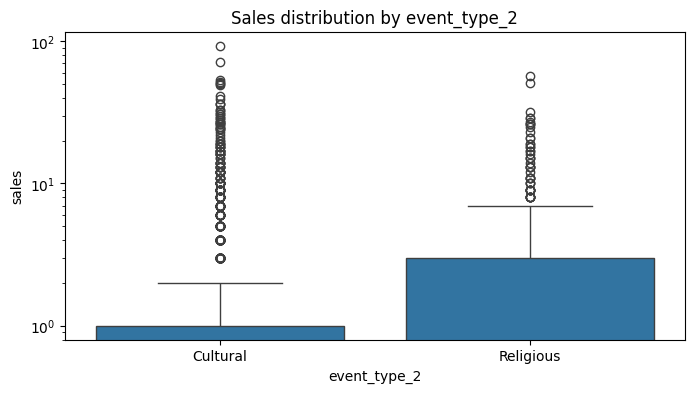

In [19]:
# Creating a boxplot of sales by 2nd‐event type
import matplotlib.pyplot as plt
import seaborn as sns

df2 = sales[sales["event_type_2"].notna() & (sales["event_type_2"]!="None")]
plt.figure(figsize=(8,4))
sns.boxplot(x="event_type_2", y="sales", data=df2)
plt.yscale("log")
plt.title("Sales distribution by event_type_2")
plt.show()

**Why drop `event_type_2`?**

1. **Extremely rare**  
   - Over 99 % of all observations have `event_type_2 = NaN`.  
   - Only a tiny fraction (< 0.2 %) of days carry any “second event” at all, so nearly every dummy we’d create would be zero.
     
2. **Very small impact on sales**  
   - On the few days that do have a second event, average sales only tick up by ~0.2–1.6 units.  
   - Compared to our typical sales volumes, this uplift is negligible.

3. **High feature‐space cost**  
   - Encoding each holiday in `event_type_2` as its own one‑hot adds four extra columns (plus “None”), all of which are almost always zero.  
   - That bloats the model with almost no signal to learn from.

4. **Redundancy with existing features**  
   - We already have `is_event` and `event_type_1` capturing the bulk of holiday effects.  
   - Any remaining “second event” influence would largely overlap with those.

In [20]:
sales = sales.drop(columns=["event_name_2", "event_type_2"])

In [21]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,series_id,id_base,d,sales,...,event_name_1,event_type_1,sell_price,is_event,snap,day,dayofweek,weekofyear,quarter,has_event2
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,CA_1_HOBBIES_1_001,HOBBIES_1_001_CA_1,d_1,0.0,...,NaN,NaN,9.58,0,0,29,5,4,1,False
1,HOBBIES_1_026_CA_1_validation,HOBBIES_1_026,HOBBIES_1,HOBBIES,CA_1,CA,CA_1_HOBBIES_1_026,HOBBIES_1_026_CA_1,d_1,0.0,...,NaN,NaN,17.97,0,0,29,5,4,1,False
2,HOBBIES_1_030_CA_1_validation,HOBBIES_1_030,HOBBIES_1,HOBBIES,CA_1,CA,CA_1_HOBBIES_1_030,HOBBIES_1_030_CA_1,d_1,0.0,...,NaN,NaN,0.80,0,0,29,5,4,1,False
3,HOBBIES_1_048_CA_1_validation,HOBBIES_1_048,HOBBIES_1,HOBBIES,CA_1,CA,CA_1_HOBBIES_1_048,HOBBIES_1_048_CA_1,d_1,0.0,...,NaN,NaN,0.50,0,0,29,5,4,1,False
4,HOBBIES_1_123_CA_1_validation,HOBBIES_1_123,HOBBIES_1,HOBBIES,CA_1,CA,CA_1_HOBBIES_1_123,HOBBIES_1_123_CA_1,d_1,0.0,...,NaN,NaN,7.79,0,0,29,5,4,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956495,FOODS_3_190_WI_3_validation,FOODS_3_190,FOODS_3,FOODS,WI_3,WI,WI_3_FOODS_3_190,FOODS_3_190_WI_3,d_1913,1.0,...,NaN,NaN,1.00,0,0,24,6,16,2,False
956496,FOODS_3_228_WI_3_validation,FOODS_3_228,FOODS_3,FOODS,WI_3,WI,WI_3_FOODS_3_228,FOODS_3_228_WI_3,d_1913,3.0,...,NaN,NaN,1.68,0,0,24,6,16,2,False
956497,FOODS_3_278_WI_3_validation,FOODS_3_278,FOODS_3,FOODS,WI_3,WI,WI_3_FOODS_3_278,FOODS_3_278_WI_3,d_1913,2.0,...,NaN,NaN,1.00,0,0,24,6,16,2,False
956498,FOODS_3_329_WI_3_validation,FOODS_3_329,FOODS_3,FOODS,WI_3,WI,WI_3_FOODS_3_329,FOODS_3_329_WI_3,d_1913,7.0,...,NaN,NaN,2.98,0,0,24,6,16,2,False


In [22]:
sales.to_csv("C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\m5_preprocessed.csv")

In [23]:
import pandas as pd

m5 = pd.read_csv("C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\m5_preprocessed.csv", parse_dates=["date"])
print("M5 PREPROCESSED")
print("Shape:", m5.shape, "\n")
print("Dtypes:\n", m5.dtypes, "\n")
print("Missing %:\n", (m5.isna().mean() * 100).sort_values(), "\n")

# per-series stats (sales by 'id')
grp = m5.groupby("id")["sales"]
stats = grp.agg(
    length     = "size",
    mean_sales = "mean",
    std_sales  = "std",
    zero_rate  = lambda s: (s==0).mean()
)
print("Per series (first 5):\n", stats.head(), "\n")
print("Distribution of per series stats:\n", stats.describe().loc[["min","25%","50%","75%","max"]])

C:\Users\Bindhu\AppData\Local\Temp\ipykernel_3732\743820624.py:3: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  m5 = pd.read_csv("C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\m5_preprocessed.csv", parse_dates=["date"])


M5 PREPROCESSED
Shape: (956500, 27) 

Dtypes:
 Unnamed: 0               int64
id                      object
item_id                 object
dept_id                 object
cat_id                  object
store_id                object
state_id                object
series_id               object
id_base                 object
d                       object
sales                  float64
date            datetime64[ns]
wm_yr_wk                 int64
weekday                 object
wday                     int64
month                    int64
year                     int64
event_name_1            object
event_type_1            object
sell_price             float64
is_event                 int64
snap                     int64
day                      int64
dayofweek                int64
weekofyear               int64
quarter                  int64
has_event2                bool
dtype: object 

Missing %:
 Unnamed: 0       0.000000
weekofyear       0.000000
dayofweek        0.000000
day       

## Feature Engineering

In [13]:
df = pd.read_csv("C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\m5_preprocessed.csv", parse_dates=["date"])
df.sort_values(["id", "date"], inplace=True)

C:\Users\Bindhu\AppData\Local\Temp\ipykernel_14256\413685949.py:1: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\m5_preprocessed.csv", parse_dates=["date"])


In [14]:
# Creating lag features
for lag in [1, 7, 14, 28, 56, 365]:
    df[f"lag_sales_{lag}"] = df.groupby("id")["sales"].shift(lag)

In [15]:
# Creating rolling mean and std features
for w in [7, 28, 56, 365]:
    grp = df.groupby("id")["sales"]
    df[f"roll_mean_{w}"] = grp.shift(1).rolling(w).mean()
    df[f"roll_std_{w}"]  = grp.shift(1).rolling(w).std()

In [16]:
# Creating price lag and rolling mean features
grp_price = df.groupby(["store_id", "item_id"])["sell_price"]
df["lag_price_1"] = grp_price.shift(1)
df["roll_price_7"] = grp_price.shift(1).rolling(7).mean()

In [17]:
# Relative price change
df['price_change_1'] = (df['sell_price'] - df['lag_price_1']) / df['lag_price_1']

In [18]:
# Cumulative sales and days since start
shifted = df.groupby('id')['sales'].shift(1)
df['cumulative_sales'] = shifted.groupby(df['id']).cumsum()

df['days_since_start'] = df.groupby('id').cumcount()

In [19]:
# One-hot encoding for categorical variables
df = pd.get_dummies(df, columns=["event_name_1","event_type_1"], dummy_na=True)

In [20]:
# Ensure datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Deriving clean numeric calendar parts
df['dayofyear']  = df['date'].dt.dayofyear          
df['weekday_nb'] = df['date'].dt.weekday           
df['month_nb']   = df['date'].dt.month               
df['weekofyear_nb'] = df['date'].dt.isocalendar().week.astype('int64')

# Cyclical encoding of calendar parts
def add_cyclical_from_series(df, s, name, period, zero_based=True):
    """
    s: numeric series
    name: base name, e.g. 'weekday'
    period: e.g. 7, 12, 53, 366
    zero_based: if s is 0..period-1 (True) or 1..period (False)
    """
    x = pd.to_numeric(s, errors='coerce')
    if not zero_based:
        x = x - 1  # make it 0..period-1
    radians = 2 * np.pi * (x % period) / period
    df[f'{name}_sin'] = np.sin(radians)
    df[f'{name}_cos'] = np.cos(radians)

# Using appropriate periods and zero-based flags
add_cyclical_from_series(df, df['dayofyear'],     'dayofyear', 366, zero_based=False)  # 1..365/366
add_cyclical_from_series(df, df['weekofyear_nb'], 'weekofyear', 53,  zero_based=False) # 1..53
add_cyclical_from_series(df, df['month_nb'],      'month',      12,  zero_based=False) # 1..12
add_cyclical_from_series(df, df['weekday_nb'],    'weekday',    7,   zero_based=True)  # 0..6

In [21]:
# Columns to drop
drop_cols = [
    "Unnamed: 0", "series_id", "id_base", "d", "wm_yr_wk",
    "weekday", "month", "weekofyear", "dayofweek", "quarter",
    "event_name_1_nan", "event_type_1_nan"
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

In [22]:
df.fillna(0, inplace=True)
df.to_csv("C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\m5_preprocessed_fe.csv", index=False)
print("Done", df.shape)

Done (956500, 80)


In [23]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'sales',
       'date', 'wday', 'year', 'sell_price', 'is_event', 'snap', 'day',
       'has_event2', 'lag_sales_1', 'lag_sales_7', 'lag_sales_14',
       'lag_sales_28', 'lag_sales_56', 'lag_sales_365', 'roll_mean_7',
       'roll_std_7', 'roll_mean_28', 'roll_std_28', 'roll_mean_56',
       'roll_std_56', 'roll_mean_365', 'roll_std_365', 'lag_price_1',
       'roll_price_7', 'price_change_1', 'cumulative_sales',
       'days_since_start', 'event_name_1_Chanukah End',
       'event_name_1_Christmas', 'event_name_1_Cinco De Mayo',
       'event_name_1_ColumbusDay', 'event_name_1_Easter',
       'event_name_1_Eid al-Fitr', 'event_name_1_EidAlAdha',
       'event_name_1_Father's day', 'event_name_1_Halloween',
       'event_name_1_IndependenceDay', 'event_name_1_LaborDay',
       'event_name_1_LentStart', 'event_name_1_LentWeek2',
       'event_name_1_MartinLutherKingDay', 'event_name_1_MemorialDay',
       'event_name_